# Plot ROI correlation matrix
Interactive/inline plotting of Shen-268 ROI time-series files.

In [1]:
# Choose backend: prefer ipympl widgets, fallback to inline
try:
    import importlib
    importlib.import_module("ipympl")
    %matplotlib ipympl
except Exception:
    %matplotlib inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.covariance import ledoit_wolf


In [3]:
def cov2corr(covariance: np.ndarray) -> np.ndarray:
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    corr = covariance / outer_v
    corr[covariance == 0] = 0
    return corr


def compute_corr(ts: np.ndarray, method: str = "pearson") -> np.ndarray:
    if ts.ndim != 2:
        raise ValueError(f"Expected 2D array (T, N_ROI), got shape {ts.shape}")

    if method == "pearson":
        return np.corrcoef(ts, rowvar=False)
    if method == "ldw":
        cov, _ = ledoit_wolf(ts, assume_centered=False)
        return cov2corr(cov)
    raise ValueError(f"Unknown method: {method}")


def plot_corr(corr: np.ndarray, title: str = "", cmap: str = "coolwarm"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap=cmap)
    ax.set_title(title or "ROI Correlation Matrix")
    ax.set_xlabel("ROI index")
    ax.set_ylabel("ROI index")
    n_roi = corr.shape[0]
    tick_step = max(1, n_roi // 10)
    ticks = np.arange(0, n_roi, tick_step)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Correlation")
    fig.tight_layout()
    plt.show()


Loaded c:\Users\USER\Documents\InternQX\Movie-HCP_Brain_Graph-master\Movie-HCP_Brain_Graph-master- test\Movie-HCP_Brain_Graph-master-test\data\all_shen_roi_ts\100610_MOVIE2_7T_PA_shen268_roi_ts_gsr.txt
Time-series shape: (918, 268) (T x N_ROI)
Correlation matrix shape: (268, 268)


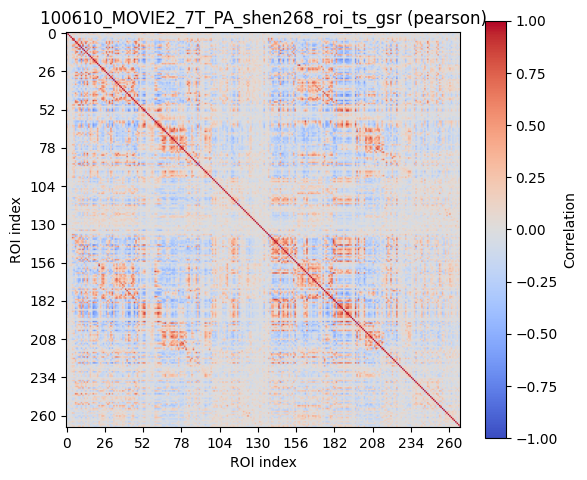

In [4]:
# Set your file path here
ts_path = Path(r"c:\Users\USER\Documents\InternQX\Movie-HCP_Brain_Graph-master\Movie-HCP_Brain_Graph-master- test\Movie-HCP_Brain_Graph-master-test\data\all_shen_roi_ts\100610_MOVIE2_7T_PA_shen268_roi_ts_gsr.txt")
method = "pearson"  # or "ldw"

ts = np.loadtxt(ts_path)
if ts.shape[0] == 268 and ts.shape[1] != 268:
    ts = ts.T
print(f"Loaded {ts_path}")
print(f"Time-series shape: {ts.shape} (T x N_ROI)")

corr = compute_corr(ts, method=method)
print("Correlation matrix shape:", corr.shape)
plot_corr(corr, title=f"{ts_path.stem} ({method})")


Label file not found: data\shen_roi_labels.txt (skipping)
Label file not found: data\shen_roi_networks.txt (skipping)


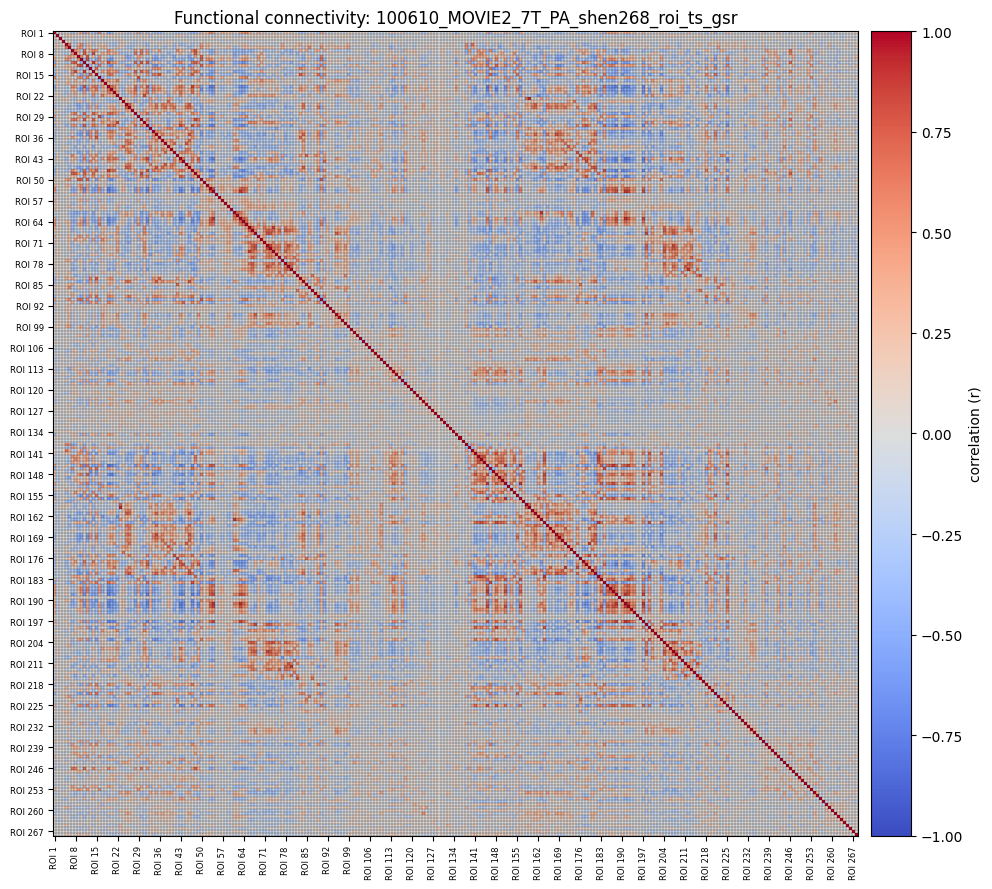

In [5]:
# Publication-style connectivity heatmap similar to the example figure
from matplotlib.colors import TwoSlopeNorm


def _maybe_load_labels(path: Path | None):
    if path is None:
        return None
    path = Path(path)
    if not path.exists():
        print(f"Label file not found: {path} (skipping)")
        return None
    labels = [line.strip() for line in path.read_text().splitlines() if line.strip()]
    return labels if labels else None


def _order_by_network(network_labels):
    order = []
    network_order = []
    sizes = []
    for label in network_labels:
        if label not in network_order:
            network_order.append(label)
    for label in network_order:
        idxs = [i for i, lab in enumerate(network_labels) if lab == label]
        order.extend(idxs)
        sizes.append(len(idxs))
    boundaries = []
    centers = []
    start = 0
    for size in sizes:
        boundaries.append(start + size)
        centers.append(start + (size - 1) / 2)
        start += size
    return order, network_order, boundaries, centers


def plot_connectivity_blocks(
    corr,
    roi_labels=None,
    network_labels=None,
    title="Functional connectivity between ICNs",
):
    corr = np.asarray(corr)
    if corr.shape[0] != corr.shape[1]:
        raise ValueError("Correlation matrix must be square")
    n = corr.shape[0]

    roi_labels = list(roi_labels) if roi_labels is not None else None
    network_labels = list(network_labels) if network_labels is not None else None

    order = np.arange(n)
    icn_names = None
    boundaries = None
    centers = None

    if network_labels is not None and len(network_labels) == n:
        order, icn_names, boundaries, centers = _order_by_network(network_labels)
        corr = corr[np.ix_(order, order)]
        if roi_labels is not None:
            roi_labels = [roi_labels[i] for i in order]
    elif network_labels is not None:
        print(f"Ignoring network labels (expected {n}, got {len(network_labels)})")

    fig, ax = plt.subplots(figsize=(10, 9))
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    im = ax.imshow(corr, cmap="coolwarm", norm=norm, origin="upper")

    ax.set_title(title, fontsize=12)

    # thin grid for each ROI
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="black", linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # ROI tick labels (sparse to reduce clutter)
    step = max(1, n // 35)
    tick_idx = np.arange(0, n, step)
    if roi_labels is None:
        roi_labels = [f"ROI {i+1}" for i in range(n)]
    ax.set_xticks(tick_idx)
    ax.set_xticklabels([roi_labels[i] for i in tick_idx], rotation=90, fontsize=6)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels([roi_labels[i] for i in tick_idx], fontsize=6)

    # overlay thicker lines + network ticks when group labels exist
    if boundaries:
        for b in boundaries[:-1]:
            ax.axhline(b - 0.5, color="black", linewidth=1.0)
            ax.axvline(b - 0.5, color="black", linewidth=1.0)
        secax_x = ax.secondary_xaxis("top")
        secax_x.set_xticks(centers)
        secax_x.set_xticklabels(icn_names, fontsize=8)
        secax_x.tick_params(length=0)
        secax_y = ax.secondary_yaxis("right")
        secax_y.set_yticks(centers)
        secax_y.set_yticklabels(icn_names, fontsize=8)
        secax_y.tick_params(length=0)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.015)
    cbar.set_label("correlation (r)")
    fig.tight_layout()
    plt.show()


# Point these to label files if you have them; otherwise the plot falls back to ROI indices.
# Each file should be plain text with one entry per ROI in the same order as the time-series columns.
roi_labels = _maybe_load_labels(Path("data/shen_roi_labels.txt"))  # e.g., "L STG"
network_labels = _maybe_load_labels(Path("data/shen_roi_networks.txt"))  # e.g., "AUD", "VIS", ...

plot_connectivity_blocks(
    corr,
    roi_labels=roi_labels,
    network_labels=network_labels,
    title=f"Functional connectivity: {ts_path.stem}",
)
